# BTK
I will use this notebook to model a Superconducting-Normal (SN) junction with a finite barrier present at the interface.

**Goal** : Conductance-Voltage characteristics 

Steps:

1. Define the Hamiltonian function for a one-dimensional region with a fixed pairing potential;

2. Define the Hamiltonian function for a S - barrier - N junction

3. Define the current calculation function using NEGF at T = 0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.optimize

## 1 : Define the Hamiltonian for a 1d region

In [82]:
def calc_Hamiltonian(params):
    '''
    params is a dict with the following paramters:
    N_z   : number of points in z 
    N_phi : number of points in azimuthal direction
    t_z   : hopping paramter along z = hbar**2/(2 m a**2) where a is lattice spacing
    t_phi : hopping paramter along phi = hbar**2/(2 m a_phi**2) where a_phi is lattice spacing along 
            azimuthal direction 
    Delta : order paramter (complex number)
    mu    : chemical potential
    flux  : flux in units of h/e
    '''
    N_z = params['N_z'] 
    N_phi = params['N_phi'] 
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta = params['Delta']
    mu = params['mu']
    flux = params['flux']
    U = params['U']
    
    def matrix_ele(e1,e2):
        '''
        Returns the matrix element between points e1 and e2
        '''
        (z1,phi1) = e1
        (z2,phi2) = e2
        # onsite element
        if z1 == z2 and phi1 == phi2:
            if N_phi != 1:
                diag_ele = 2*t_z + np.abs(t_phi)*(2 - (2*np.pi*flux/N_phi)**2) - mu + U
            else:
                # diagonal elemenet for N_phi = 1 does not make sense
                diag_ele = 2*t_z - mu + U
            return np.array([[diag_ele,Delta],[np.conj(Delta),-np.conj(diag_ele)]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
        
    # the basis is given by (n_z,n_phi) where n_z = 0,..,N_z-1, n_phi = 0,...,N_phi-1
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H = [matrix_ele(e1,e2) for e1 in basis for e2 in basis]
    N = N_phi*N_z

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(2*N,2*N)

    return H_mat

## 2 : Define the surface Green's function calculation 

In [50]:
def calc_surface_g(E,params,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
    eta is used to calculated the Green's function
    eps controls the accuracy
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    H = calc_Hamiltonian(params)   
    eta = params['eta']
    surface_dof = 2*params['N_phi']
    alpha = H[:surface_dof,:surface_dof]
    beta = H[:surface_dof,surface_dof:2*surface_dof]
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g


## 3 : Define the current calculation function using NEGF

In [57]:
def calc_T(E,params):
    '''
    Returns the density of states for a SNS device
    '''
    if type(E) != np.ndarray:
        E = np.array([E])
    eta = params['eta']
    N_z = params['N_z']
    N_phi = params['N_phi']
    mu_S = params['mu_S']
    mu_N = params['mu_N']
    flux = params['flux']
    trans = params['trans']
    
    S_params = {
        'N_z' : 2,
        'N_phi' : N_phi,
        'Delta' : params['Delta_S'],
        'mu' : mu_S,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
        'U' : 0,
    }
    
    barrier_params = {
        'N_z' : N_z,
        'N_phi' : N_phi,
        'Delta' : 0,
        'mu' : (mu_N + mu_S)/2,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
        'U' : params['U']
    }
    
    N_params = {
        'N_z' : 2,
        'N_phi' : N_phi,
        'Delta' : 0,
        'mu' : mu_N,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
        'U' : 0,
    }

    g_1 = calc_surface_g(E,S_params,eta)
    g_2 = calc_surface_g(E,N_params,eta)
    
    H_mat = calc_Hamiltonian(barrier_params)
   
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1)))
    
    Gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))
    Gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))
    
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]).reshape(1,H_mat.shape[0],H_mat.shape[1])
                      - H_mat - trans*sigma_1 - trans*sigma_2)
 
    T = np.real(np.trace(Gamma_1 @ G @ Gamma_2 @ np.transpose(np.conj(G),(0,2,1)),axis1=-1,axis2=-2)) 
    return T
    

In [58]:
# testing of T vs E calculation
# phase diff between S1 and S2
bias = 2e-3
params = {
    'N_z' : 10,
    'N_phi' : 1,
    'flux' : 0,
    't_z' : 100e-3,
    'Delta_S' : 1e-3,
    'mu_S' : 20e-3 + bias/2,
    'mu_N' : 20e-3 - bias/2,
    'trans' : 1.0,
    'U' : 0,
}
params['t_phi'] = 0e-3*np.exp(1j*2*np.pi*params['flux']/params['N_phi'])

E_vec = np.linspace(-params['mu_N'],params['mu_N'],100)
eta = 0.1*(E_vec[1] - E_vec[0])

params['eta'] = eta
T_vec = calc_T(E_vec,params)

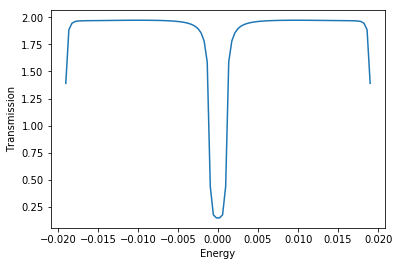

In [59]:
plt.figure(1)
plt.plot(E_vec,T_vec)
plt.xlabel('Energy')
plt.ylabel('Transmission')

## Results
- Current vs bias
- Conductance vs bias

In [70]:
def calc_current(params):
    '''
    Calculates the current for given bias inferred from params
    '''
    bias = params['mu_S'] - params['mu_N']
    current = scipy.integrate.quad(calc_T,-bias,bias,args=(params),epsrel=1e-4)
    return current

In [91]:
mu_eq_S = 10e-3
mu_eq_N = 10e-3
params = {
    'N_z' : 2,
    'N_phi' : 1,
    'flux' : 0,
    't_z' : 100e-3,
    'Delta_S' : 1e-3,
    'trans' : 1,
    'U' : 0e-3,
}
params['t_phi'] = 0e-3*np.exp(1j*2*np.pi*params['flux']/params['N_phi'])
params['eta'] = 1e-5

bias_vec = np.linspace(-2e-3,2e-3,20)
current_vec = []
for bias in bias_vec:
    print(bias)
    params['mu_S'] = mu_eq_S + bias/2
    params['mu_N'] = mu_eq_N - bias/2 
    current_vec.append(calc_current(params)[0])
current_vec = np.array(current_vec)

-0.002
-0.00178947368421
-0.00157894736842
-0.00136842105263
-0.00115789473684
-0.000947368421053
-0.000736842105263
-0.000526315789474
-0.000315789473684
-0.000105263157895
0.000105263157895
0.000315789473684
0.000526315789474
0.000736842105263
0.000947368421053
0.00115789473684
0.00136842105263
0.00157894736842
0.00178947368421
0.002


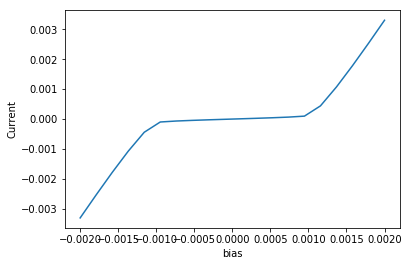

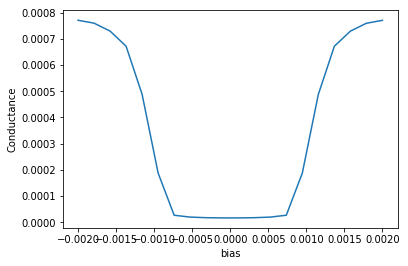

In [92]:
plt.figure(1)
plt.plot(bias_vec,current_vec)
plt.xlabel('bias')
plt.ylabel('Current')
plt.figure(2)
plt.plot(bias_vec,np.gradient(current_vec))
plt.xlabel('bias')
plt.ylabel('Conductance')